# <center> Projet TC6: Criteo Display Advertising Challenge </center>
## <center> Expériences </center>
  
<center>Trung VUTHANH,   Malik KAZI,    Nour NOUREDINE</center>


Ce second notebook contient nos premières expérimentation lors de la prise en main du projet. Voir le notebook Rapport pour le résumé.

In [1]:
import findspark
findspark.init()
import pyspark
import re

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql.functions import rand
from pyspark.sql.functions import avg
from pyspark.sql.types import *

In [3]:
sc = SparkContext('local')

In [4]:
sc.version

'2.4.0'

# I. Données et pre-traitement de données

Les données se trouve à http://labs.criteo.com/2014/02/download-kaggle-display-advertising-challenge-dataset/?fbclid=IwAR0y5NGoecgyTheFdqT6vBjQVVIz47FCQD48aeOIfyOy-adcZcDj8iRgLJU . Description de données:

- train.txt : L'ensemble d'entraînement consiste en une partie du trafic de Criteo sur une période de 7 jours. Chaque ligne correspond à une annonce d'affichage desservie par Criteo. Les exemples positifs (cliqués) et négatifs (sans clic) ont tous deux été sous-échantillonnés à des taux différents afin de réduire la taille du DataSet. Les exemples sont classés chronologiquement.

- test.txt: Le jeu de test est calculé de la même manière que l'ensemble de train, mais pour les événements le jour suivant de l'entraînement.


A cause de la limite de ressources et matériels, nous ne pouvons que prendre une petite partie de données pour traitement

In [ ]:
# Indiquer le chemin vers le fichier train.txt dans la variable path ci 
# training_file_path ci dessous :
training_file_path = '../criteo/dac/train.txt'
new_file_path = '../criteo/dac/train_partition.txt'

In [ ]:
# Création d'échantillons de données, décommenter une des ligne et relancer la cellule pour choisir le nombre
# d'exemples à prendre en compte
!head -200000 $training_file_path > $new_file_path

In [5]:
# chargement de données depuis local, n'oublie pas de changer le nom de votre répertoire

spark = SparkSession(sc)
df1 = spark.read.load(new_file_path,format="csv",sep="\t", inferSchema="true", header="true")

- le train comprends de 50 colonnes: 49 colonnes de features et 1 colonnes de labels. 
- Chaque exemple a 49 features dont 13 premiers (marqué i1 à i13) sont de type numéric (integer) et 26 restants sont de type texte (string)

In [6]:
# rajout de headers au tableau csv de données

new_headers=['label','i1','i2','i3','i4','i5','i6','i7','i8','i9','i10','i11','i12','i13','c1','c2','c3','c4','c5','c6',\
'c7','c8','c9','c10','c11','c12','c13','c14','c15','c16','c17','c18','c19','c20','c21','c22','c23','c24','c25','c26']
df1=df1.toDF(*new_headers)

#### remplir tous les valeurs null de données
- pour les features numéric, remplacer valeurs null par la moyenne de cette colonne
- pour les features catégorique, remplacer valeurs null par une valeur aléatoire dans cette colonne (sauf null évidemment)

In [7]:
# remplacement valeurs null par la moyenne de cette colonne

def fill_with_mean(this_df, include=set()):

    stats = this_df.agg(*(avg(c).alias(c) for c in this_df.columns if c in include))
    return this_df.na.fill(stats.first().asDict())



df_fill_i = fill_with_mean(df1, ['i1','i2','i3','i4','i5','i6','i7','i8','i9','i10','i11','i12','i13'])
df_fill_i.show(5)

+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|label| i1| i2| i3| i4|   i5| i6| i7| i8| i9|i10|i11|i12|i13|      c1|      c2|      c3|      c4|      c5|      c6|      c7|      c8|      c9|     c10|     c11|     c12|     c13|     c14|     c15|     c16|     c17|     c18|     c19|     c20|     c21|     c22|     c23|     c24|     c25|     c26|
+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    0|  2|  0| 44|  1|  102|  8|  2|  2|  4|  1|  1|  0|  4|68fd1e64|f0cf0024|6f67f7e5|41274cd7|25c83c98|fe6b92

In [8]:
# remplacer valeurs null par une valeur aléatoire non-null dans cette colonne

cate_columns={}
#from random import randint
#print(randint(1, 9))
c_columns=['c1','c2','c3','c4','c5','c6',\
'c7','c8','c9','c10','c11','c12','c13','c14','c15','c16','c17','c18','c19','c20','c21','c22','c23','c24','c25','c26']
for column in c_columns:
    v_is_null = True
    print("traitement column",column)
    while v_is_null:
        v = df_fill_i.select(column).orderBy(rand()).limit(1).collect()[0][column]
        if v:
            v_is_null = False
    #grouped = df_fill_i.groupBy(column).count().sort(desc("count"))
    cate_columns[column] = v
df_full = df_fill_i.fillna(cate_columns)
df_full.show(5)

traitement column c1
traitement column c2
traitement column c3
traitement column c4
traitement column c5
traitement column c6
traitement column c7
traitement column c8
traitement column c9
traitement column c10
traitement column c11
traitement column c12
traitement column c13
traitement column c14
traitement column c15
traitement column c16
traitement column c17
traitement column c18
traitement column c19
traitement column c20
traitement column c21
traitement column c22
traitement column c23
traitement column c24
traitement column c25
traitement column c26
+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|label| i1| i2| i3| i4|   i5| i6| i7| i8| i9|i10|i11|i12|i13|      c1|      c2|      c3|      c4|      c5|      c6|      c7|      c8|      c9

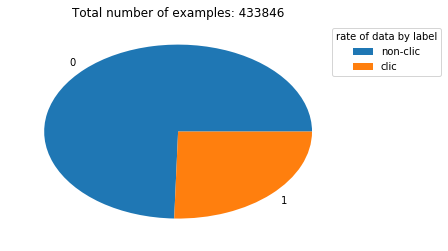

In [43]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show


describe = df_full.describe('i3')
nb_exemples = describe.filter(describe['summary']=='count').collect()[0]['i3']
ingredients = ['non-clic', 'clic']

label_df = df_full.toPandas()
label_series = label_df['label']
s = label_series.value_counts()
#s.plot.pie()
fig, ax = plt.subplots( nrows=1, ncols=1 )
wedges, texts = ax.pie(s, labels=s.index)
ax.legend(wedges, ingredients,
          title="rate of data by label",
          loc="upper right", bbox_to_anchor=(0.8, 0, 0.5, 1))

ax.set_title("Total number of examples: "+nb_exemples)
plt.show()
#print(data1)

#### Convertir features catégorielles en numéric pour entrainer les modeles

In [9]:
#only Indexer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder

#for column in c_columns:
columns_in = ['c1','c2','c3','c4','c5','c6',\
'c7','c8','c9','c10','c11','c12','c13','c14','c15','c16','c17','c18','c19','c20','c21','c22','c23','c24','c25','c26']
#columns_out = ['c1vec','c2vec','c3vec','c4vec','c5vec','c6vec','c7vec','c8vec','c9vec','c10vec','c11vec','c12vec',\
#'c13vec','c14vec','c15vec','c16vec','c17vec','c18vec','c19vec','c20vec','c21vec','c22vec','c23vec','c24vec','c25vec','c26vec']
 
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_full) for column in columns_in]
    
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df_full).transform(df_full)
df_r.show()

+-----+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|label| i1| i2| i3| i4|   i5| i6| i7| i8|  i9|i10|i11|i12|i13|      c1|      c2|      c3|      c4|      c5|      c6|      c7|      c8|      c9|     c10|     c11|     c12|     c13|     c14|     c15|     c16|     c17|     c18|     c19|     c20|     c21|     c22|     c23|     c24|     c25|     c26|c1_index|c2_index|c3_index|c4_index|c5_index|c6_index|c7_index|c8_index|c9_index|c10_index|c11_index|c12_index|c13_index|c14_index|c15_index|c16_index|c17_i

#### compter les nombres de valeurs distinctes pour chaque feature

In [48]:
for colum in df_full.columns:
    print(colum+":", df_full.select(colum).distinct().count(), 'distinct values')


label: 2 distinct values
i1: 224 distinct values
i2: 3605 distinct values
i3: 1478 distinct values
i4: 177 distinct values
i5: 52629 distinct values
i6: 3188 distinct values
i7: 1081 distinct values
i8: 281 distinct values
i9: 2683 distinct values
i10: 9 distinct values
i11: 114 distinct values
i12: 115 distinct values
i13: 370 distinct values
c1: 984 distinct values
c2: 525 distinct values
c3: 159077 distinct values
c4: 70119 distinct values
c5: 223 distinct values
c6: 13 distinct values
c7: 9965 distinct values
c8: 461 distinct values
c9: 3 distinct values
c10: 21972 distinct values
c11: 4439 distinct values
c12: 138448 distinct values
c13: 3021 distinct values
c14: 26 distinct values
c15: 7642 distinct values
c16: 110047 distinct values
c17: 10 distinct values
c18: 3439 distinct values
c19: 1693 distinct values
c20: 3 distinct values
c21: 126096 distinct values
c22: 13 distinct values
c23: 15 distinct values
c24: 27596 distinct values
c25: 60 distinct values
c26: 21048 distinct valu

# II. Modèle Random Forest

Enlève des colonnes categorielles qui restent encore après transformation

In [10]:
#columns_to_drop = ['c3', 'c4', 'c10','c12','c16','c21','c24', 'c26']
df_r=df_r.drop(*columns_in)
    
df_r.show(5)
df_r.printSchema()

+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|label| i1| i2| i3| i4|   i5| i6| i7| i8| i9|i10|i11|i12|i13|c1_index|c2_index|c3_index|c4_index|c5_index|c6_index|c7_index|c8_index|c9_index|c10_index|c11_index|c12_index|c13_index|c14_index|c15_index|c16_index|c17_index|c18_index|c19_index|c20_index|c21_index|c22_index|c23_index|c24_index|c25_index|c26_index|
+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|    0|  2|  0| 44|  1|  102|  8|  2|  2|  4|  1|  1|  0|  4|

#### A la limite de resources, il est très couteux au niveau de temps d'execution avec RandomForest pour les colonnes categorielle ayant trop de valeurs discretes. Donc, nous ne garderions que les colonnes qui a moins de 4000 valeurs pour entrainement.

In [11]:
oversized_columns = ['c3_index','c4_index','c10_index','c12_index','c16_index','c21_index',\
                     'c24_index','c26_index','c7_index','c11_index','c15_index']
df_r1=df_r.drop(*oversized_columns)
    
df_r1.show(5)

+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|label| i1| i2| i3| i4|   i5| i6| i7| i8| i9|i10|i11|i12|i13|c1_index|c2_index|c5_index|c6_index|c8_index|c9_index|c13_index|c14_index|c17_index|c18_index|c19_index|c20_index|c22_index|c23_index|c25_index|
+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|    0|  2|  0| 44|  1|  102|  8|  2|  2|  4|  1|  1|  0|  4|     1.0|    17.0|     0.0|     2.0|     0.0|     0.0|    662.0|      0.0|      1.0|     28.0|      1.0|      2.0|      0.0|      1.0|      2.0|
|    0|  2|  0|  1| 14|  767| 89|  4|  2|245|  1|  3|  3| 45|    24.0|    44.0|     0.0|     0.0|     0.0|     0.0|    602.0|      1.0|      7.0|    390.0|      0.0|      0.0| 

In [12]:
cols_now = ['i1','i2','i3','i4','i5','i6','i7','i8','i9','i10','i11','i12','i13','c1_index','c2_index',\
    'c5_index','c6_index','c8_index','c9_index','c13_index',\
'c14_index','c17_index','c18_index','c19_index','c20_index','c22_index',\
    'c23_index','c25_index']

In [13]:
#cols_now = ['i1','i2','i3','i4','i5','i6','i7','i8','i9','i10','i11','i12','i13','c1_index','c2_index','c3_index',\
#    'c4_index','c5_index','c6_index','c7_index','c8_index','c9_index','c10_index','c11_index','c12_index','c13_index',\
# 'c14_index','c15_index','c16_index','c17_index','c18_index','c19_index','c20_index','c21_index','c22_index',\
#    'c23_index','c24_index','c25_index','c26_index']
assembler_features = VectorAssembler(inputCols=cols_now, outputCol='features')
labelIndexer = StringIndexer(inputCol='label', outputCol="labelIndex")
tmp = [assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

##### Diviser le jeux données en train et test

In [14]:
allData = pipeline.fit(df_r1).transform(df_r1)
#allData.cache()
trainingData, testData = allData.randomSplit([0.75,0.25], seed=105) # need to ensure same split for each time
#print("Distribution of Pos and Neg in trainingData is: ", trainingData.groupBy("label").count().take(3))


In [15]:
allData.printSchema()

root
 |-- label: integer (nullable = true)
 |-- i1: integer (nullable = true)
 |-- i2: integer (nullable = true)
 |-- i3: integer (nullable = true)
 |-- i4: integer (nullable = true)
 |-- i5: integer (nullable = true)
 |-- i6: integer (nullable = true)
 |-- i7: integer (nullable = true)
 |-- i8: integer (nullable = true)
 |-- i9: integer (nullable = true)
 |-- i10: integer (nullable = true)
 |-- i11: integer (nullable = true)
 |-- i12: integer (nullable = true)
 |-- i13: integer (nullable = true)
 |-- c1_index: double (nullable = false)
 |-- c2_index: double (nullable = false)
 |-- c5_index: double (nullable = false)
 |-- c6_index: double (nullable = false)
 |-- c8_index: double (nullable = false)
 |-- c9_index: double (nullable = false)
 |-- c13_index: double (nullable = false)
 |-- c14_index: double (nullable = false)
 |-- c17_index: double (nullable = false)
 |-- c18_index: double (nullable = false)
 |-- c19_index: double (nullable = false)
 |-- c20_index: double (nullable = false)


In [18]:
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.feature import IndexToString, VectorIndexer
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RF(labelCol='labelIndex', featuresCol='features', numTrees=200, maxBins=4000)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

In [49]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
raw_probas = transformed.select(['probability', 'labelIndex'])
 
results = raw_probas.collect()
list_results = [(float(i[0][0]), 1.0-float(i[1])) for i in results]
score_labels = sc.parallelize(list_results)
 
metrics = metric(score_labels)
print("The ROC score of model RandomForest is: ", metrics.areaUnderROC)


The ROC score of model RandomForest is:  0.7052804042593378


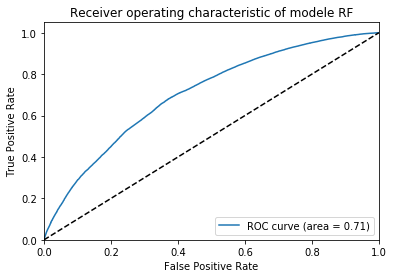

In [50]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
false_positive_r = dict()
true_positive_r = dict()
roc_auc = dict()
 
y_test = [i[1] for i in list_results]
y_score = [i[0] for i in list_results]
 
false_positive_r, true_positive_r, _ = roc_curve(y_test, y_score)
roc_auc = auc(false_positive_r, true_positive_r)
 
%matplotlib inline
plt.figure()
plt.plot(false_positive_r, true_positive_r, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of modele RF')
plt.legend(loc="lower right")
plt.show()

### RandomForest avec K-fold cross validation

In [18]:
#from pyspark.ml import Pipeline
#from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.feature import IndexToString, VectorIndexer
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#trainingData = ... # DataFrame[label: double, features: vector]
numFolds = 4 # Integer

rf1 = RF(labelCol='labelIndex', featuresCol='features',numTrees=200,maxBins=4000)
evaluator = BinaryClassificationEvaluator(labelCol="labelIndex") # + other params as in Scala
paramGrid = ParamGridBuilder().build()
pipeline_KFold = Pipeline(stages=[rf1])

crossval = CrossValidator(estimator=pipeline_KFold,estimatorParamMaps=paramGrid,evaluator=evaluator,numFolds=numFolds)

model = crossval.fit(trainingData)

In [22]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

transformed1 = model.transform(testData)
results1 = transformed1.select(['probability', 'labelIndex'])
 
## prepare score-label set
results_collect1 = results1.collect()
results_list1 = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect1]
scoreAndLabels1 = sc.parallelize(results_list1)
 
metrics1 = metric(scoreAndLabels1)
print("The ROC score is (@numTrees=200): ", metrics1.areaUnderROC)


The ROC score is (@numTrees=200):  0.7049962771931013


In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(transformed1, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.704996277193085


# III. Modele Gradient Boost Tree

In [16]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model
gbt = GBTClassifier(labelCol="labelIndex", featuresCol="features", maxBins=4000, maxIter=50)

modelGB = gbt.fit(trainingData)


In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions.
predictions = modelGB.transform(testData)

# Compute test accuracy
evaluator = BinaryClassificationEvaluator(labelCol="labelIndex", rawPredictionCol="prediction")
print("Test: Area Under ROC of Gradient Boost Tree: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC of Gradient Boost Tree: 0.6232253494091387
